In [2]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [4]:
import random

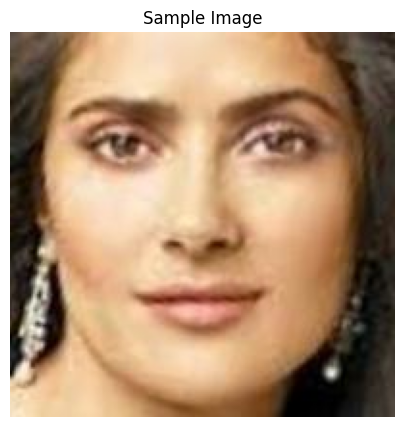

In [8]:

# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)
num_images_to_select = int(0.75 * len(image_paths))
selected_image_paths = random.sample(image_paths, num_images_to_select)

gender_mapping = ["Male", "Female"]

rand_image_path = np.random.choice(selected_image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [9]:
# Initialize a male counter
male_count = 0
ages = []
for path in selected_image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

#total female counts
female_count = len(selected_image_paths) - male_count

In [10]:
import seaborn as sns

/tmp/ipykernel_34/2794015913.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ages)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

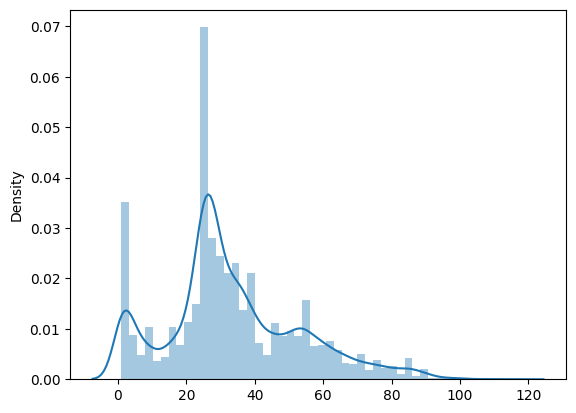

In [11]:
sns.distplot(ages)

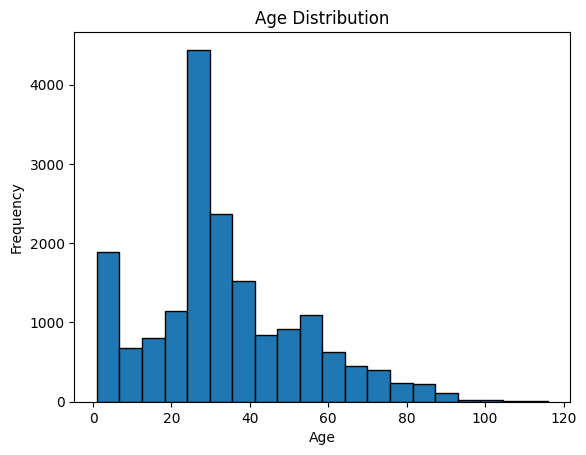

In [12]:
# Histogram of age
plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [18]:
import plotly.express as px
female_count = len(image_paths) - male_count
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

In [13]:
# SHuffling the Images
np.random.shuffle(selected_image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    selected_image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    selected_image_paths,
    train_size = 0.9,
    test_size = 0.1
)

In [14]:
print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

Training Size : 16002
Testing Size  : 1779


In [20]:
# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]

In [21]:
valid_ages = [int(path.split("_")[0]) for path in valid_images]

In [22]:
test_ages = [int(path.split("_")[0]) for path in test_images]

In [23]:
def preprocess_age_data(selected_image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    image = tf.io.read_file(dir_path + selected_image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)
    return image, age

In [24]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [25]:
valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [26]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

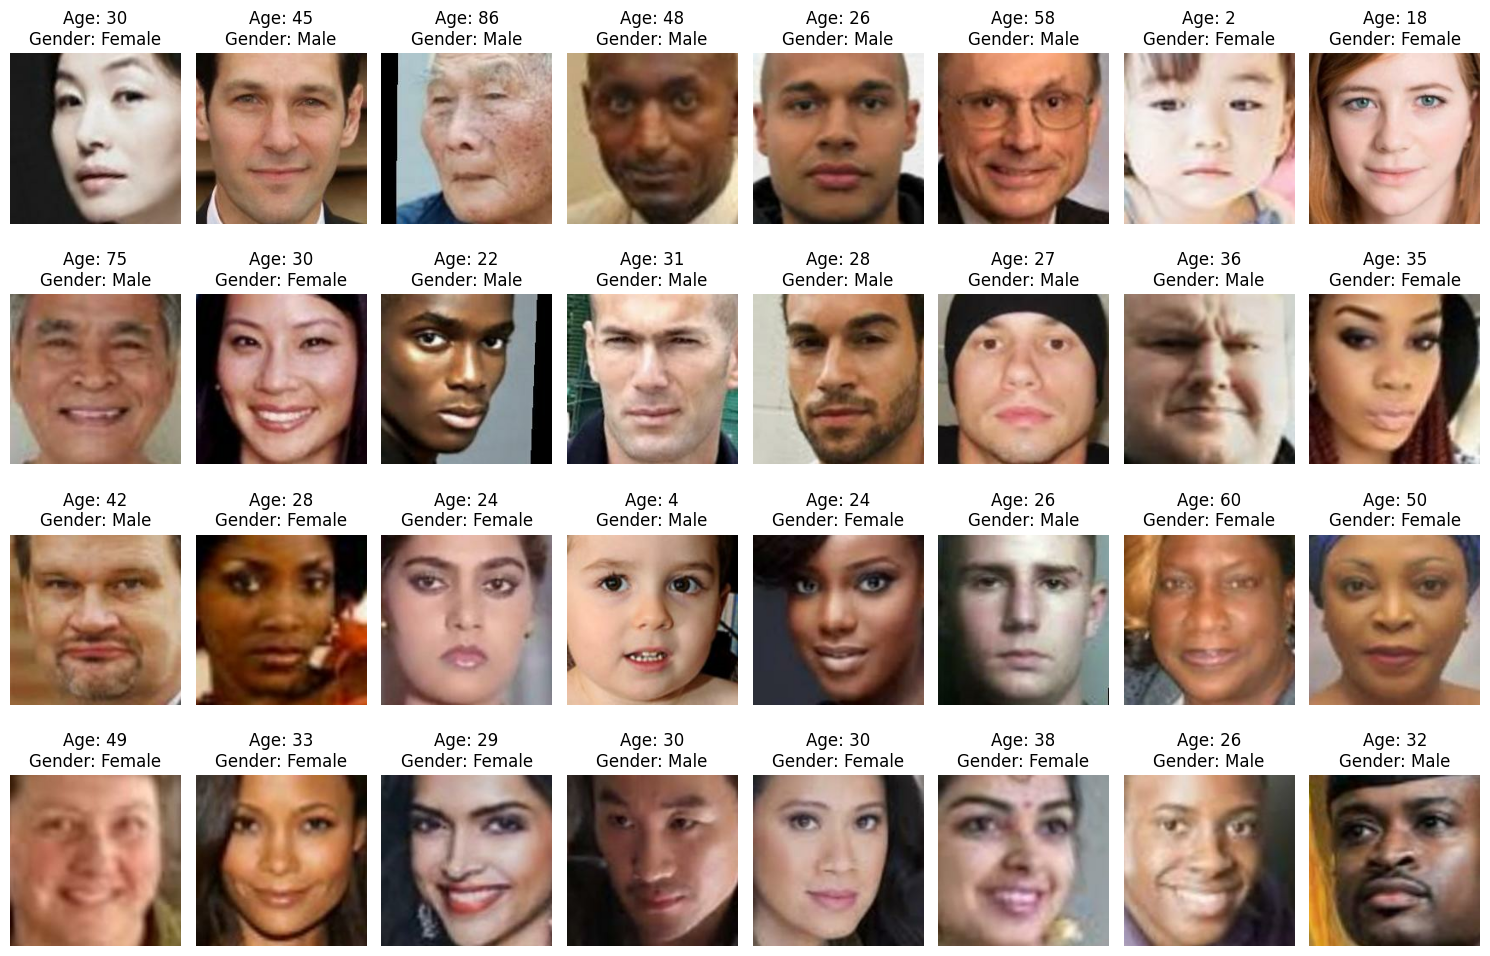

In [27]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(2):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [96]:
# Trining the Age Model
age_history = age_net.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE
)

Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 6.2925 - val_loss: 11.5379
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.3617 - val_loss: 406.1555
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.2932 - val_loss: 33.9652
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - loss: 6.5700 - val_loss: 1204.6268
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.3088 - val_loss: 16.1053
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.1325 - val_loss: 235.3396
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.0813 - val_loss: 373.5540
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 5.9059 - val_loss: 39.5213
Epoch 9/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.3152 - val_loss: 596.4799
Epoch 10/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 6.3244 - val_loss: 703.2622
Epoch 11/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 5.8183 - val_loss: 52.7758
Epoch 12/20


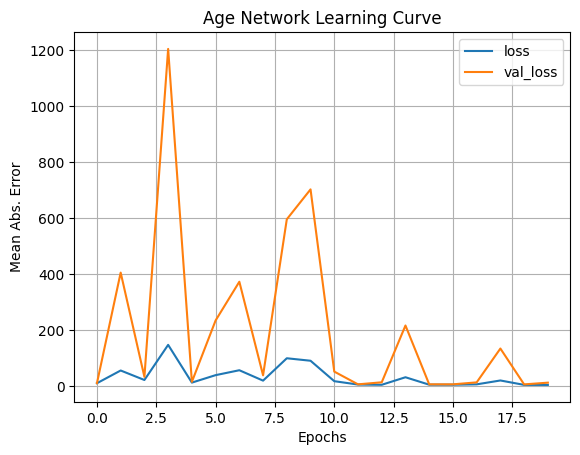

In [97]:
# Converting history into data frame.
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

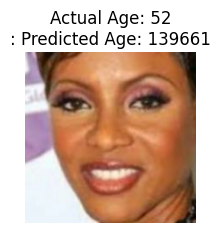

In [101]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)-31):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        
        # Predictions
        pred_age = tf.round(tf.squeeze(age_net.predict(image, verbose=0)), 2)

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Actual Age: {ages[index]}\n: Predicted Age: {int(pred_age)}")
        plt.axis("off")

plt.tight_layout()
plt.show()

**ERROR IN THE CLASSIFYING AGE**